In [16]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("WARNING: No GPU detected! Training will be very slow.")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.83 GB


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from pathlib import Path
import json
from IPython.display import clear_output
import time

print("✓ All libraries imported successfully")


✓ All libraries imported successfully


In [18]:
def get_num_groups(channels):
    """Get the largest valid num_groups for GroupNorm that divides channels"""
    for num_groups in [32, 16, 8, 4, 2, 1]:
        if channels % num_groups == 0:
            return num_groups
    return 1

def count_parameters(model):
    """Count trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_samples(samples, epoch, save_path=None):
    """Plot generated samples in a grid"""
    samples = samples.cpu()
    samples = (samples + 1) / 2  # Scale to [0, 1]
    samples = samples.clamp(0, 1)

    fig, axes = plt.subplots(8, 8, figsize=(12, 12))
    for idx, ax in enumerate(axes.flat):
        if idx < len(samples):
            img = samples[idx].permute(1, 2, 0).numpy()
            ax.imshow(img)
        ax.axis('off')

    plt.suptitle(f'Generated Samples - Epoch {epoch}', fontsize=16)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=100, bbox_inches='tight')
    plt.show()

print("✓ Utility functions defined")


✓ Utility functions defined


In [19]:
class SinusoidalTimeEmbedding(nn.Module):
    """Sinusoidal positional embeddings for time steps"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = t[:, None] * embeddings[None, :]
        embeddings = torch.cat([embeddings.sin(), embeddings.cos()], dim=-1)
        return embeddings

print("✓ Time embedding module defined")

✓ Time embedding module defined


In [20]:
class ResBlock(nn.Module):
    """Residual block with time and class conditioning via FiLM"""
    def __init__(self, in_channels, out_channels, time_emb_dim, class_emb_dim, dropout=0.1):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Main convolution path
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)

        # GroupNorm for stability
        self.norm1 = nn.GroupNorm(get_num_groups(in_channels), in_channels)
        self.norm2 = nn.GroupNorm(get_num_groups(out_channels), out_channels)

        # FiLM conditioning
        cond_dim = time_emb_dim + class_emb_dim
        self.film = nn.Linear(cond_dim, out_channels * 2)

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Skip connection
        self.skip = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, emb):
        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)

        # Apply FiLM conditioning
        film_params = self.film(emb)[:, :, None, None]
        scale, shift = torch.chunk(film_params, 2, dim=1)
        h = h * (1 + scale) + shift

        h = self.norm2(h)
        h = F.silu(h)
        h = self.dropout(h)
        h = self.conv2(h)

        return h + self.skip(x)

print("✓ ResBlock defined")

✓ ResBlock defined


In [21]:
class AttentionBlock(nn.Module):
    """Lightweight self-attention"""
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        assert channels % num_heads == 0

        self.norm = nn.GroupNorm(get_num_groups(channels), channels)
        self.qkv = nn.Conv2d(channels, channels * 3, 1)
        self.proj = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        qkv = self.qkv(h)

        # Reshape for multi-head attention
        qkv = qkv.reshape(B, 3, self.num_heads, C // self.num_heads, H * W)
        qkv = qkv.permute(1, 0, 2, 4, 3)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Attention
        scale = (C // self.num_heads) ** -0.5
        attn = torch.softmax(torch.matmul(q, k.transpose(-2, -1)) * scale, dim=-1)
        h = torch.matmul(attn, v)

        # Reshape back
        h = h.permute(0, 1, 3, 2).reshape(B, C, H, W)
        h = self.proj(h)

        return x + h

print("✓ Attention block defined")


✓ Attention block defined


In [22]:
class Downsample(nn.Module):
    """Downsampling with convolution"""
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, 3, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)


class Upsample(nn.Module):
    """Upsampling with convolution"""
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, 3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)

print("✓ Downsample and Upsample modules defined")

✓ Downsample and Upsample modules defined


In [23]:
class TinyUNet(nn.Module):
    """
    Tiny UNet for CIFAR-10 (32x32 images)
    Target: < 1.5M parameters
    Used for both DDPM and CFM
    """
    def __init__(
        self,
        in_channels=3,
        out_channels=3,
        base_channels=32,
        channel_mults=(1, 2, 2),
        num_res_blocks=2,
        attention_resolutions=(16,),
        num_classes=10,
        dropout=0.1,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_classes = num_classes
        self.num_res_blocks = num_res_blocks

        # Time embedding
        time_emb_dim = base_channels * 4
        self.time_mlp = nn.Sequential(
            SinusoidalTimeEmbedding(base_channels),
            nn.Linear(base_channels, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        # Class embedding
        class_emb_dim = base_channels * 4
        self.class_emb = nn.Embedding(num_classes + 1, class_emb_dim)

        # Initial convolution
        self.conv_in = nn.Conv2d(in_channels, base_channels, 3, padding=1)

        # Build encoder blocks
        self.encoder_blocks = nn.ModuleList()
        self.encoder_attns = nn.ModuleList()
        self.downsamplers = nn.ModuleList()

        ch_in = base_channels
        resolution = 32

        for level, mult in enumerate(channel_mults):
            ch_out = base_channels * mult

            blocks = nn.ModuleList()
            for _ in range(num_res_blocks):
                blocks.append(ResBlock(ch_in, ch_out, time_emb_dim, class_emb_dim, dropout))
                ch_in = ch_out
            self.encoder_blocks.append(blocks)

            if resolution in attention_resolutions:
                self.encoder_attns.append(AttentionBlock(ch_out))
            else:
                self.encoder_attns.append(None)

            if level < len(channel_mults) - 1:
                self.downsamplers.append(Downsample(ch_out))
                resolution //= 2
            else:
                self.downsamplers.append(None)

        # Middle blocks
        self.mid_block1 = ResBlock(ch_in, ch_in, time_emb_dim, class_emb_dim, dropout)
        self.mid_attn = AttentionBlock(ch_in)
        self.mid_block2 = ResBlock(ch_in, ch_in, time_emb_dim, class_emb_dim, dropout)

        # Build decoder blocks
        self.decoder_blocks = nn.ModuleList()
        self.decoder_attns = nn.ModuleList()
        self.upsamplers = nn.ModuleList()

        for level, mult in reversed(list(enumerate(channel_mults))):
            ch_out = base_channels * mult

            blocks = nn.ModuleList()
            for i in range(num_res_blocks + 1):
                if i == 0:
                    blocks.append(ResBlock(ch_in + ch_out, ch_out, time_emb_dim, class_emb_dim, dropout))
                else:
                    blocks.append(ResBlock(ch_in, ch_out, time_emb_dim, class_emb_dim, dropout))
                ch_in = ch_out
            self.decoder_blocks.append(blocks)

            if resolution in attention_resolutions:
                self.decoder_attns.append(AttentionBlock(ch_out))
            else:
                self.decoder_attns.append(None)

            if level > 0:
                self.upsamplers.append(Upsample(ch_out))
                resolution *= 2
            else:
                self.upsamplers.append(None)

        # Final output
        self.norm_out = nn.GroupNorm(get_num_groups(ch_in), ch_in)
        self.conv_out = nn.Conv2d(ch_in, out_channels, 3, padding=1)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x, t, y):
        """
        Args:
            x: (B, C, H, W) - input images
            t: (B,) - time steps in [0, 1]
            y: (B,) - class labels
        """
        # Compute embeddings
        t_emb = self.time_mlp(t)
        y_emb = self.class_emb(y)
        emb = torch.cat([t_emb, y_emb], dim=1)

        # Initial convolution
        h = self.conv_in(x)

        # Store skip connections
        skips = []

        # Encoder
        for blocks, attn, downsample in zip(self.encoder_blocks, self.encoder_attns, self.downsamplers):
            for block in blocks:
                h = block(h, emb)
            skips.append(h)
            if attn is not None:
                h = attn(h)
            if downsample is not None:
                h = downsample(h)

        # Middle
        h = self.mid_block1(h, emb)
        h = self.mid_attn(h)
        h = self.mid_block2(h, emb)

        # Decoder
        for blocks, attn, upsample in zip(self.decoder_blocks, self.decoder_attns, self.upsamplers):
            skip = skips.pop()
            h = torch.cat([h, skip], dim=1)
            for block in blocks:
                h = block(h, emb)
            if attn is not None:
                h = attn(h)
            if upsample is not None:
                h = upsample(h)

        # Final output
        h = self.norm_out(h)
        h = F.silu(h)
        h = self.conv_out(h)

        return h

print("✓ TinyUNet model defined")


✓ TinyUNet model defined


In [24]:
class ConditionalFlowMatching:
    """
    Conditional Flow Matching (CFM)

    Based on "Flow Matching for Generative Modeling" (Lipman et al., 2023)
    Simpler and faster than DDPM!
    """
    def __init__(self, sigma_min=1e-4):
        self.sigma_min = sigma_min

    def compute_loss(self, model, x0, y, cfg_dropout_prob=0.1):
        """
        Compute CFM training loss (velocity matching)

        Args:
            model: UNet model that predicts velocity field
            x0: clean images (B, C, H, W)
            y: class labels (B,)
            cfg_dropout_prob: probability of unconditional training

        Returns:
            loss: MSE between predicted and target velocity
        """
        batch_size = x0.shape[0]
        device = x0.device

        # Sample random time steps uniformly in [0, 1]
        t = torch.rand(batch_size, device=device)

        # Sample noise (x1)
        x1 = torch.randn_like(x0)

        # Classifier-free guidance: randomly drop conditioning
        if cfg_dropout_prob > 0:
            mask = torch.rand(batch_size, device=device) < cfg_dropout_prob
            y = torch.where(mask, torch.full_like(y, model.num_classes), y)

        # Interpolate: x_t = (1-t)*x1 + t*x0 with added noise
        # This is the "conditional" flow: from noise x1 to data x0
        t_expanded = t.view(-1, 1, 1, 1)

        # Add small noise for stability (optional Gaussian conditional path)
        sigma_t = self.sigma_min
        noise = torch.randn_like(x0) * sigma_t

        x_t = (1 - t_expanded) * x1 + t_expanded * x0 + noise

        # Target velocity: dx/dt = x0 - x1
        # This is the "straight path" from x1 to x0
        target_velocity = x0 - x1

        # Predict velocity with model
        predicted_velocity = model(x_t, t, y)

        # MSE loss
        loss = F.mse_loss(predicted_velocity, target_velocity)

        return loss

print("✓ CFM class defined")

✓ CFM class defined


In [25]:
def sample_cfm(
    model,
    num_samples,
    num_classes,
    device='cuda',
    num_steps=50,
    cfg_scale=2.0,
    class_labels=None,
):
    """
    Sample from CFM using Euler ODE solver

    CFM is MUCH FASTER than DDPM - only needs 20-50 steps!

    Args:
        model: trained UNet (velocity predictor)
        num_samples: number of images to generate
        num_classes: number of classes
        device: device to use
        num_steps: number of ODE steps (20-50 is usually enough!)
        cfg_scale: classifier-free guidance scale
        class_labels: specific class labels (optional)

    Returns:
        samples: (num_samples, 3, 32, 32) generated images
    """
    model.eval()

    # Start from pure noise (x1)
    x = torch.randn(num_samples, 3, 32, 32, device=device)

    # Sample or use provided class labels
    if class_labels is None:
        y = torch.randint(0, num_classes, (num_samples,), device=device)
    else:
        y = class_labels.to(device)

    # Unconditional labels for CFG
    y_uncond = torch.full_like(y, model.num_classes)

    # Time steps from 0 to 1
    dt = 1.0 / num_steps

    with torch.no_grad():
        for step in tqdm(range(num_steps), desc="CFM Sampling", leave=False):
            # Current time
            t = torch.full((num_samples,), step * dt, device=device)

            # Predict velocity with classifier-free guidance
            if cfg_scale > 1.0:
                v_cond = model(x, t, y)
                v_uncond = model(x, t, y_uncond)
                v = v_uncond + cfg_scale * (v_cond - v_uncond)
            else:
                v = model(x, t, y)

            # Euler step: x = x + v * dt
            x = x + v * dt

    # Clamp to valid range
    x = torch.clamp(x, -1, 1)
    return x

print("✓ CFM sampling function defined")

✓ CFM sampling function defined


In [26]:
class CFMTrainer:
    """Training loop for Conditional Flow Matching"""
    def __init__(
        self,
        model,
        optimizer,
        cfm,
        device='cuda',
        use_amp=True,
        grad_accum_steps=1,
    ):
        self.model = model
        self.optimizer = optimizer
        self.cfm = cfm
        self.device = device
        self.use_amp = use_amp
        self.grad_accum_steps = grad_accum_steps

        # Mixed precision
        self.scaler = torch.cuda.amp.GradScaler() if use_amp else None

        # Move model to device
        self.model.to(device)

    def train_epoch(self, dataloader, epoch, cfg_dropout_prob=0.1):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        num_batches = 0

        pbar = tqdm(dataloader, desc=f"Epoch {epoch}")
        for batch_idx, (images, labels) in enumerate(pbar):
            images = images.to(self.device)
            labels = labels.to(self.device)

            # Forward pass
            with torch.amp.autocast('cuda', enabled=self.use_amp):
                loss = self.cfm.compute_loss(self.model, images, labels, cfg_dropout_prob)
                loss = loss / self.grad_accum_steps

            # Backward pass
            if self.scaler is not None:
                self.scaler.scale(loss).backward()
            else:
                loss.backward()

            # Gradient accumulation
            if (batch_idx + 1) % self.grad_accum_steps == 0:
                if self.scaler is not None:
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                else:
                    self.optimizer.step()
                self.optimizer.zero_grad()

            # Logging
            total_loss += loss.item() * self.grad_accum_steps
            num_batches += 1
            pbar.set_postfix({'loss': total_loss / num_batches})

        return total_loss / num_batches

print("✓ CFMTrainer class defined")


✓ CFMTrainer class defined


In [27]:
def get_dataloaders(batch_size=32, num_workers=2):
    """Prepare CIFAR-10 dataloaders"""
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test
    )

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True, drop_last=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )

    return train_loader, test_loader

print("✓ Data loading functions defined")

✓ Data loading functions defined


In [28]:
config = {
    'base_channels': 28,
    'channel_mults': [1, 2, 2],
    'num_res_blocks': 2,
    'attention_resolutions': [16],
    'dropout': 0.1,
    'batch_size': 32,
    'lr': 3e-4,
    'lr_min': 1e-4,
    'weight_decay': 0.01,
    'cfg_dropout_prob': 0.1,
    'cfg_scale': 2.0,
    'use_amp': True,
    'grad_accum_steps': 1,
    'num_workers': 2,
    'epochs': 20,  # CFM often needs fewer epochs than DDPM!
    'save_every': 10,
    'sample_every': 10,
    'sampling_steps': 50,  # CFM only needs 20-50 steps (vs 100+ for DDPM)
}

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create output directory (use Google Drive for persistence)
from google.colab import drive
drive.mount('/content/drive')
output_dir = Path('/content/drive/MyDrive/CFM_Project/outputs')
output_dir.mkdir(parents=True, exist_ok=True)
print(f"✓ Saving to: {output_dir}")

# Initialize model (SAME architecture as DDPM for fair comparison)
model = TinyUNet(
    in_channels=3,
    out_channels=3,
    base_channels=config['base_channels'],
    channel_mults=config['channel_mults'],
    num_res_blocks=config['num_res_blocks'],
    attention_resolutions=config['attention_resolutions'],
    num_classes=10,
    dropout=config['dropout'],
)

num_params = count_parameters(model)
print(f"Model parameters: {num_params:,}")

# Initialize CFM
cfm = ConditionalFlowMatching(sigma_min=1e-4)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = CosineAnnealingLR(optimizer, T_max=config['epochs'], eta_min=config['lr_min'])

# Trainer
trainer = CFMTrainer(
    model=model,
    optimizer=optimizer,
    cfm=cfm,
    device=device,
    use_amp=config['use_amp'],
    grad_accum_steps=config['grad_accum_steps'],
)

# Get dataloaders
train_loader, test_loader = get_dataloaders(config['batch_size'], config['num_workers'])

print(f"\n{'='*60}")
print("Configuration Summary:")
print(f"{'='*60}")
for key, value in config.items():
    print(f"  {key:25s}: {value}")
print(f"{'='*60}")
print("\n✓ Everything initialized and ready to train!")


Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Saving to: /content/drive/MyDrive/CFM_Project/outputs
Model parameters: 1,340,895


/tmp/ipython-input-530059586.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler() if use_amp else None



Configuration Summary:
  base_channels            : 28
  channel_mults            : [1, 2, 2]
  num_res_blocks           : 2
  attention_resolutions    : [16]
  dropout                  : 0.1
  batch_size               : 32
  lr                       : 0.0003
  lr_min                   : 0.0001
  weight_decay             : 0.01
  cfg_dropout_prob         : 0.1
  cfg_scale                : 2.0
  use_amp                  : True
  grad_accum_steps         : 1
  num_workers              : 2
  epochs                   : 20
  save_every               : 10
  sample_every             : 10
  sampling_steps           : 50

✓ Everything initialized and ready to train!


Starting fresh training

Training CFM from epoch 0 to 20
CFM is FASTER than DDPM - expect better results sooner!



Epoch 0: 100%|██████████| 1562/1562 [01:37<00:00, 16.10it/s, loss=0.406]


Epoch 0/20: Loss=0.4055, LR=0.000299 | Time=97.0s | ETA=calculating... | 5.0% done
  → Saved best model (loss=0.4055)


Epoch 1: 100%|██████████| 1562/1562 [01:34<00:00, 16.54it/s, loss=0.245]


Epoch 1/20: Loss=0.2449, LR=0.000295 | Time=94.5s | ETA=calculating... | 10.0% done
  → Saved best model (loss=0.2449)


Epoch 2: 100%|██████████| 1562/1562 [01:34<00:00, 16.49it/s, loss=0.224]


Epoch 2/20: Loss=0.2239, LR=0.000289 | Time=94.7s | ETA=calculating... | 15.0% done
  → Saved best model (loss=0.2239)


Epoch 3: 100%|██████████| 1562/1562 [01:34<00:00, 16.46it/s, loss=0.215]


Epoch 3/20: Loss=0.2147, LR=0.000281 | Time=94.9s | ETA=calculating... | 20.0% done
  → Saved best model (loss=0.2147)


Epoch 4: 100%|██████████| 1562/1562 [01:34<00:00, 16.55it/s, loss=0.208]


Epoch 4/20: Loss=0.2083, LR=0.000271 | Time=94.4s | ETA=calculating... | 25.0% done
  → Saved best model (loss=0.2083)


Epoch 5: 100%|██████████| 1562/1562 [01:34<00:00, 16.55it/s, loss=0.204]


Epoch 5/20: Loss=0.2036, LR=0.000259 | Time=94.4s | ETA=22m | 30.0% done
  → Saved best model (loss=0.2036)


Epoch 6: 100%|██████████| 1562/1562 [01:34<00:00, 16.57it/s, loss=0.201]


Epoch 6/20: Loss=0.2010, LR=0.000245 | Time=94.3s | ETA=20m | 35.0% done
  → Saved best model (loss=0.2010)


Epoch 7: 100%|██████████| 1562/1562 [01:34<00:00, 16.49it/s, loss=0.199]


Epoch 7/20: Loss=0.1990, LR=0.000231 | Time=94.7s | ETA=19m | 40.0% done
  → Saved best model (loss=0.1990)


Epoch 8: 100%|██████████| 1562/1562 [01:34<00:00, 16.53it/s, loss=0.197]


Epoch 8/20: Loss=0.1969, LR=0.000216 | Time=94.5s | ETA=17m | 45.0% done
  → Saved best model (loss=0.1969)


Epoch 9: 100%|██████████| 1562/1562 [01:33<00:00, 16.66it/s, loss=0.195]


Epoch 9/20: Loss=0.1950, LR=0.000200 | Time=93.8s | ETA=16m | 50.0% done
  → Saved best model (loss=0.1950)
  Generating samples (CFM only needs 50 steps!)...


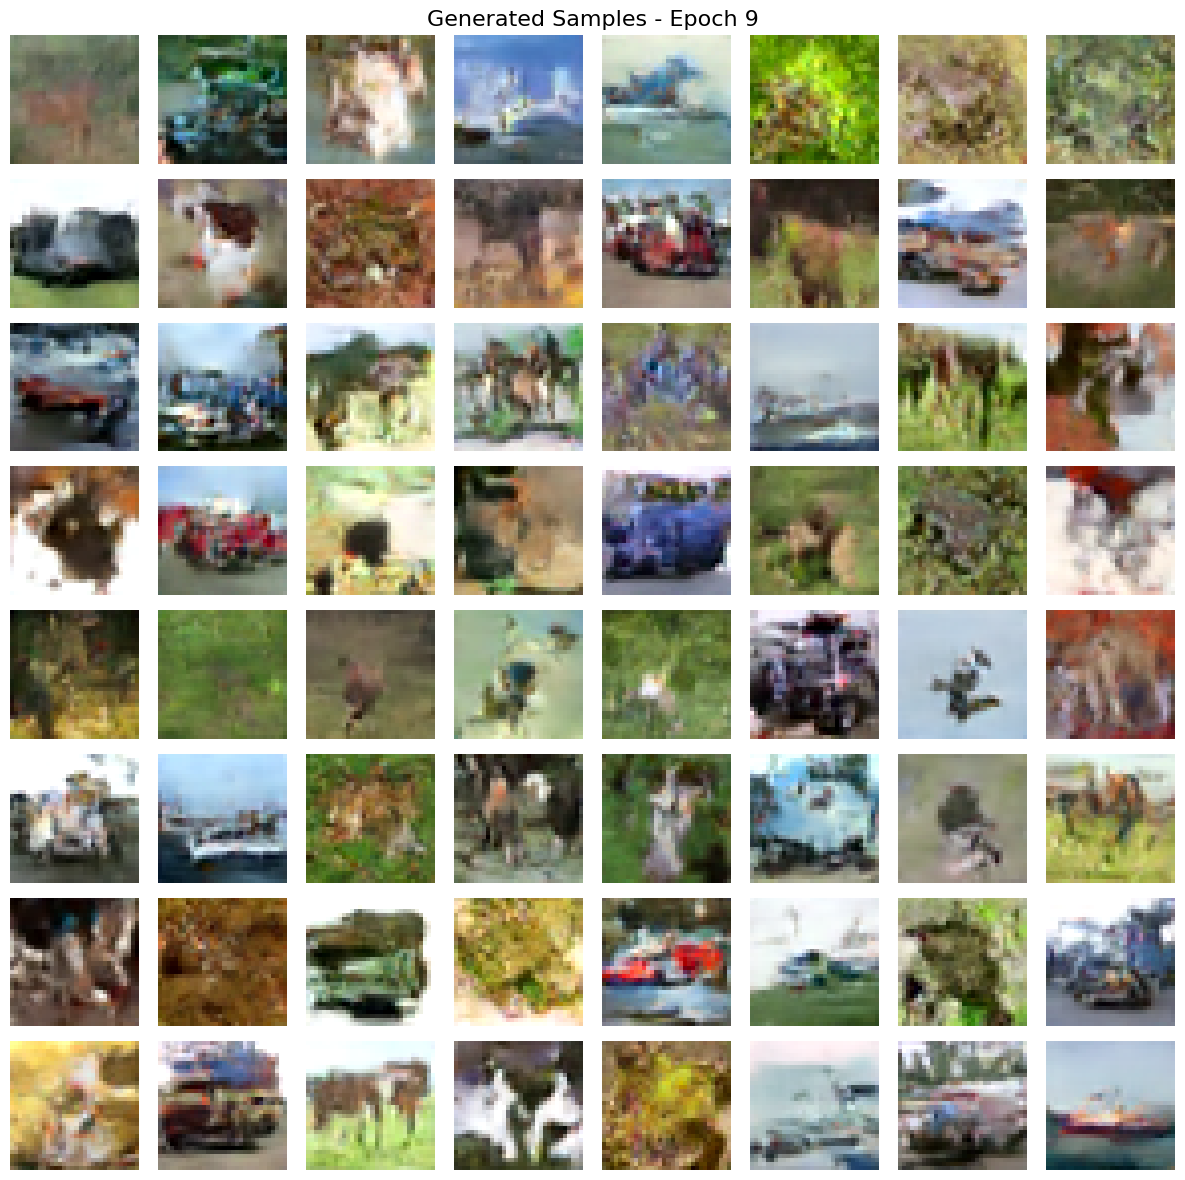

Epoch 10: 100%|██████████| 1562/1562 [01:38<00:00, 15.82it/s, loss=0.194]


Epoch 10/20: Loss=0.1940, LR=0.000184 | Time=98.7s | ETA=14m | 55.0% done
  → Saved best model (loss=0.1940)


Epoch 11: 100%|██████████| 1562/1562 [01:40<00:00, 15.47it/s, loss=0.193]


Epoch 11/20: Loss=0.1933, LR=0.000169 | Time=101.0s | ETA=13m | 60.0% done
  → Saved best model (loss=0.1933)


Epoch 12: 100%|██████████| 1562/1562 [01:39<00:00, 15.65it/s, loss=0.193]


Epoch 12/20: Loss=0.1933, LR=0.000155 | Time=99.8s | ETA=11m | 65.0% done


Epoch 13: 100%|██████████| 1562/1562 [01:41<00:00, 15.40it/s, loss=0.192]


Epoch 13/20: Loss=0.1921, LR=0.000141 | Time=101.4s | ETA=10m | 70.0% done
  → Saved best model (loss=0.1921)


Epoch 14: 100%|██████████| 1562/1562 [01:40<00:00, 15.50it/s, loss=0.191]


Epoch 14/20: Loss=0.1909, LR=0.000129 | Time=100.8s | ETA=8m | 75.0% done
  → Saved best model (loss=0.1909)


Epoch 15: 100%|██████████| 1562/1562 [01:40<00:00, 15.49it/s, loss=0.19]


Epoch 15/20: Loss=0.1899, LR=0.000119 | Time=100.9s | ETA=7m | 80.0% done
  → Saved best model (loss=0.1899)


Epoch 16: 100%|██████████| 1562/1562 [01:40<00:00, 15.59it/s, loss=0.189]


Epoch 16/20: Loss=0.1887, LR=0.000111 | Time=100.2s | ETA=5m | 85.0% done
  → Saved best model (loss=0.1887)


Epoch 17: 100%|██████████| 1562/1562 [01:40<00:00, 15.62it/s, loss=0.189]


Epoch 17/20: Loss=0.1895, LR=0.000105 | Time=100.0s | ETA=3m | 90.0% done


Epoch 18: 100%|██████████| 1562/1562 [01:39<00:00, 15.64it/s, loss=0.188]


Epoch 18/20: Loss=0.1882, LR=0.000101 | Time=99.9s | ETA=2m | 95.0% done
  → Saved best model (loss=0.1882)


Epoch 19: 100%|██████████| 1562/1562 [01:38<00:00, 15.78it/s, loss=0.189]


Epoch 19/20: Loss=0.1889, LR=0.000100 | Time=99.0s | ETA=0m | 100.0% done
  Generating samples (CFM only needs 50 steps!)...


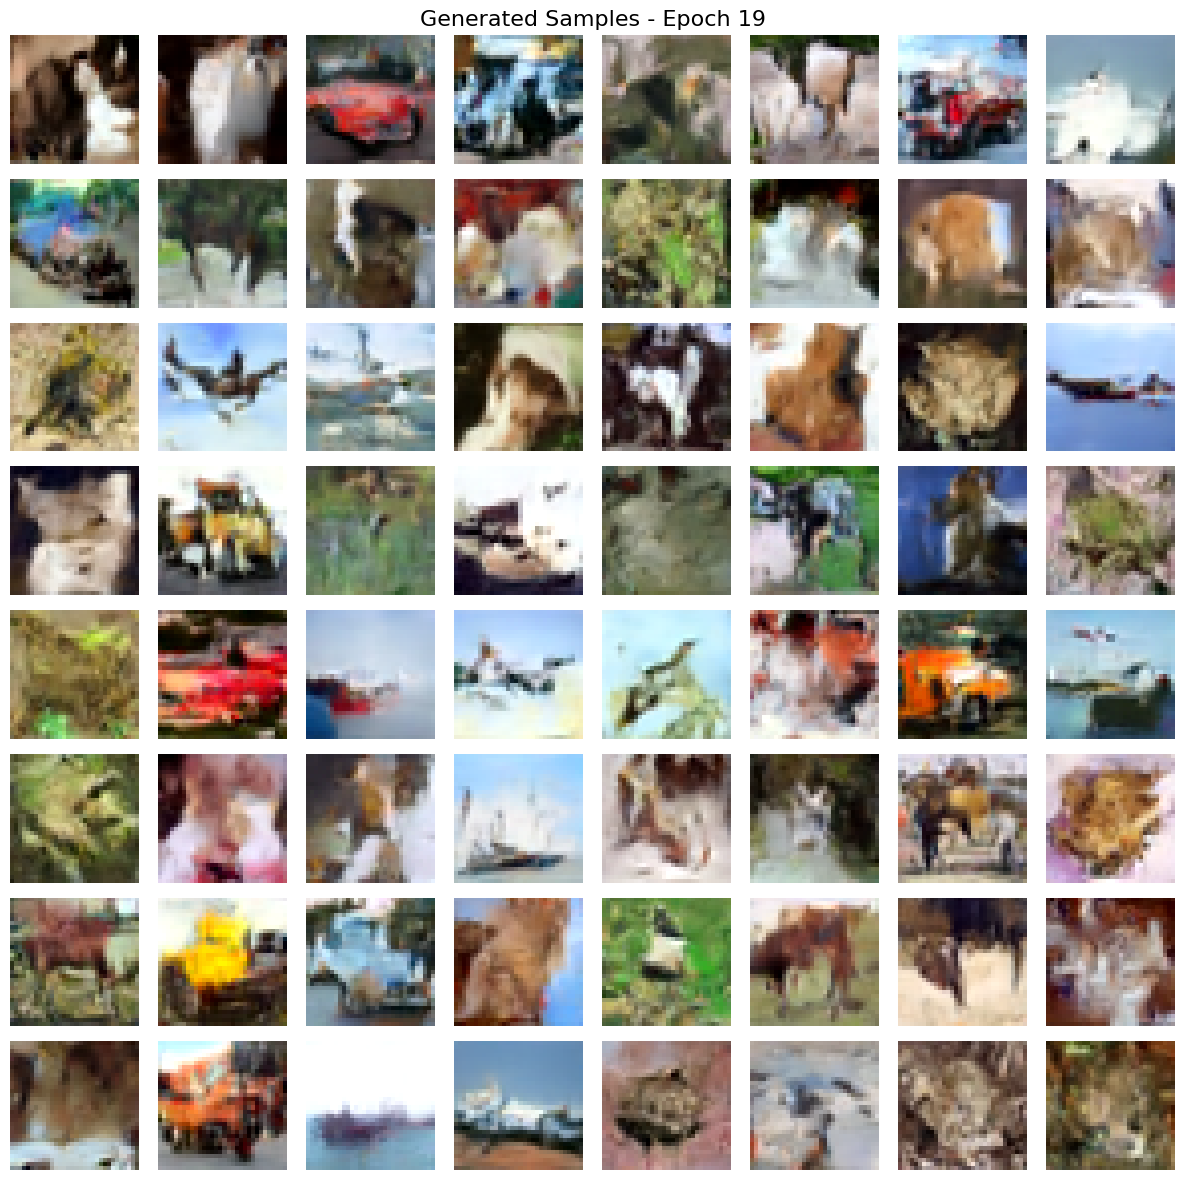


Training completed!
Best loss: 0.1882
Total time: 0.54 hours


In [30]:
import json
from pathlib import Path
import time

# Load existing history if resuming
start_epoch = 0
best_loss = float('inf')

history_path = output_dir / 'training_history.json'
if history_path.exists():
    with open(history_path, 'r') as f:
        training_history = json.load(f)
    print(f"✓ Loaded existing training history ({len(training_history)} epochs)")

    if training_history:
        start_epoch = training_history[-1]['epoch'] + 1
        best_loss = min([h['train_loss'] for h in training_history])
        print(f"✓ Resuming from epoch {start_epoch}")
else:
    training_history = []
    print("Starting fresh training")

print(f"\n{'='*60}")
print(f"Training CFM from epoch {start_epoch} to {config['epochs']}")
print(f"CFM is FASTER than DDPM - expect better results sooner!")
print(f"{'='*60}\n")

epoch_times = []

for epoch in range(start_epoch, config['epochs']):
    epoch_start_time = time.time()

    # Train one epoch
    train_loss = trainer.train_epoch(train_loader, epoch, config['cfg_dropout_prob'])

    # Update learning rate
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]

    # Calculate time
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    # Estimate remaining time
    if len(epoch_times) > 5:
        avg_time = sum(epoch_times[-5:]) / 5
        remaining = config['epochs'] - epoch - 1
        eta_hours = (avg_time * remaining) / 3600
        eta_str = f"{eta_hours:.1f}h" if eta_hours > 1 else f"{eta_hours*60:.0f}m"
    else:
        eta_str = "calculating..."

    progress = (epoch - start_epoch + 1) / (config['epochs'] - start_epoch) * 100

    print(f"Epoch {epoch}/{config['epochs']}: Loss={train_loss:.4f}, LR={current_lr:.6f} | "
          f"Time={epoch_time:.1f}s | ETA={eta_str} | {progress:.1f}% done")

    # Save training history IMMEDIATELY
    training_history.append({
        'epoch': epoch,
        'train_loss': train_loss,
        'lr': current_lr,
        'epoch_time': epoch_time,
    })

    # Save history every epoch
    with open(output_dir / 'training_history.json', 'w') as f:
        json.dump(training_history, f, indent=2)

    # Save checkpoints
    if (epoch + 1) % config['save_every'] == 0 or train_loss < best_loss:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'config': config,
        }

        torch.save(checkpoint, output_dir / 'checkpoint_latest.pt')

        if train_loss < best_loss:
            best_loss = train_loss
            torch.save(checkpoint, output_dir / 'checkpoint_best.pt')
            print(f"  → Saved best model (loss={best_loss:.4f})")

    # Generate samples periodically
    if (epoch + 1) % config['sample_every'] == 0:
        print(f"  Generating samples (CFM only needs {config['sampling_steps']} steps!)...")
        samples = sample_cfm(
            model, num_samples=64, num_classes=10,
            device=device, num_steps=config['sampling_steps'],
            cfg_scale=config['cfg_scale']
        )
        plot_samples(samples, epoch, save_path=output_dir / f'samples_epoch_{epoch}.png')

print(f"\n{'='*60}")
print(f"Training completed!")
print(f"Best loss: {best_loss:.4f}")
print(f"Total time: {sum(epoch_times)/3600:.2f} hours")
print(f"{'='*60}")


Loaded checkpoint from epoch 18 with loss 0.1882

Generating samples for each class...
Generating airplane...


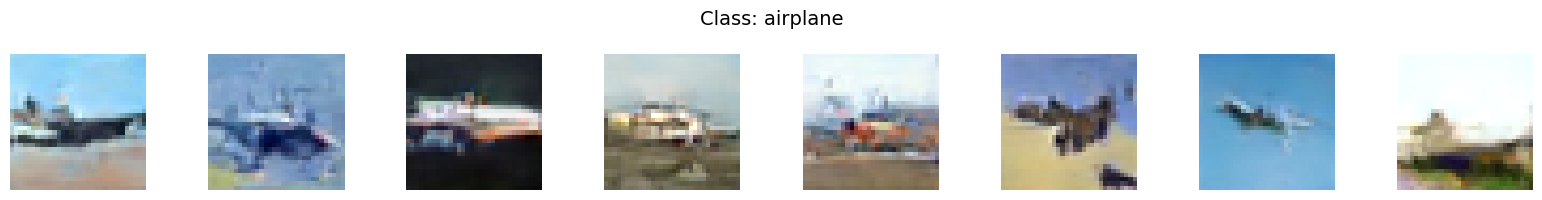

Generating automobile...


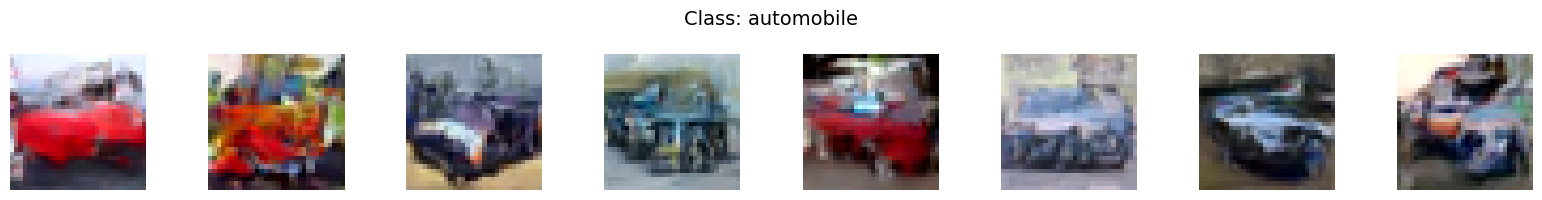

Generating bird...


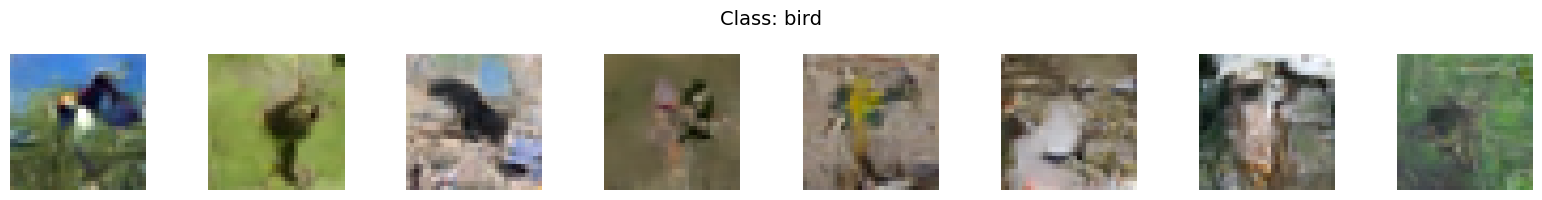

Generating cat...


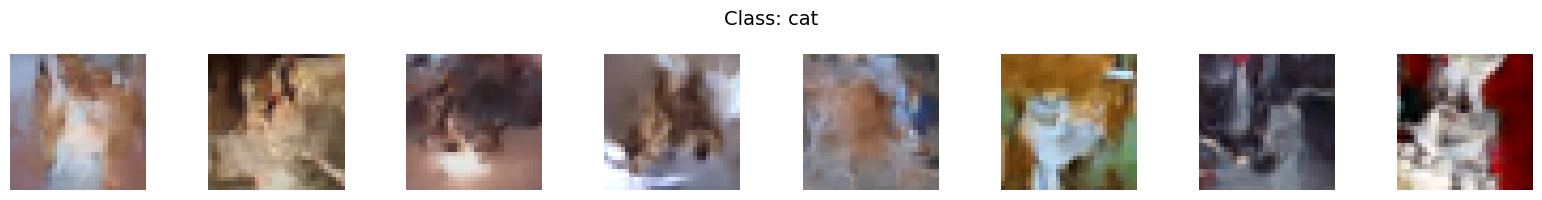

Generating deer...


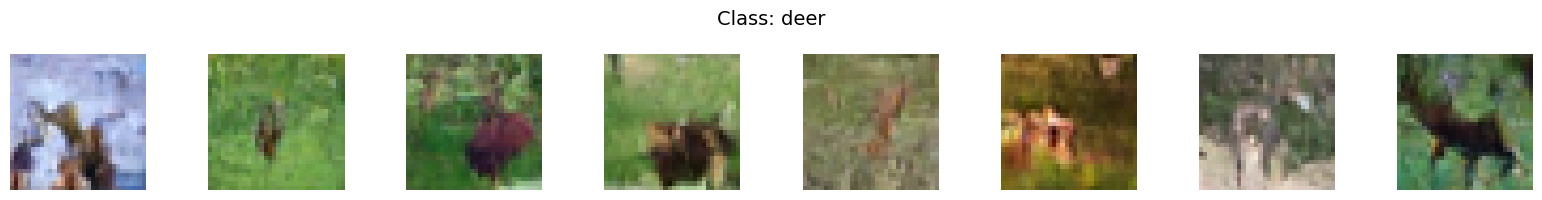

Generating dog...


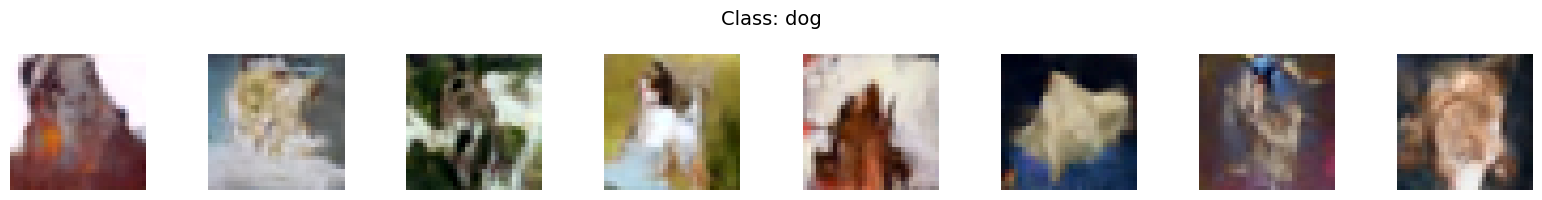

Generating frog...


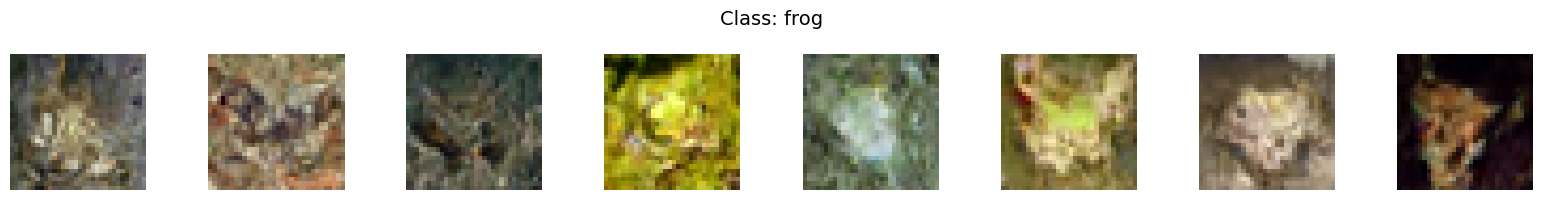

Generating horse...


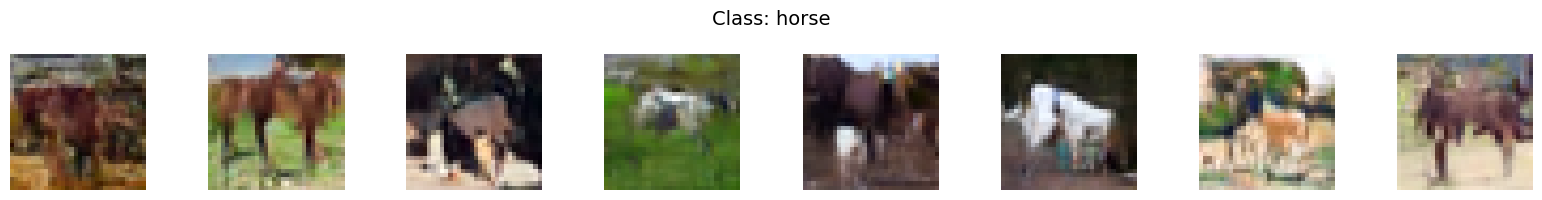

Generating ship...


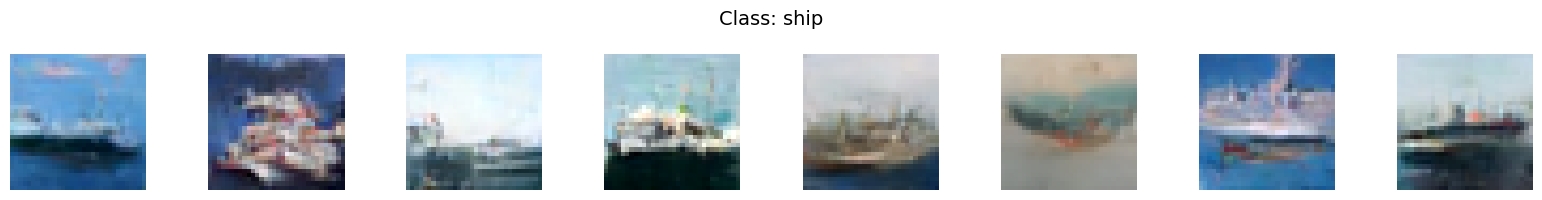

Generating truck...


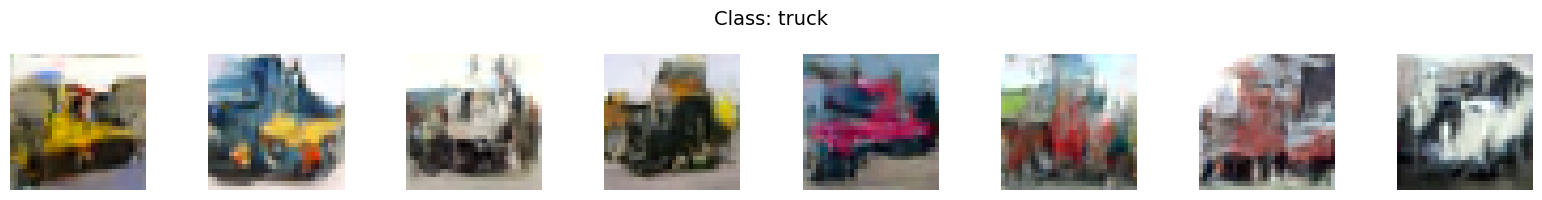


✓ All class-specific samples generated!


In [31]:
checkpoint = torch.load(output_dir / 'checkpoint_best.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded checkpoint from epoch {checkpoint['epoch']} with loss {checkpoint['train_loss']:.4f}")

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Generate samples for each class
print("\nGenerating samples for each class...")
num_samples_per_class = 8

for class_id in range(10):
    print(f"Generating {class_names[class_id]}...")
    class_labels = torch.full((num_samples_per_class,), class_id, dtype=torch.long)

    # CFM sampling is FAST - only needs 50 steps!
    samples = sample_cfm(
        model,
        num_samples=num_samples_per_class,
        num_classes=10,
        device=device,
        num_steps=config['sampling_steps'],
        cfg_scale=config['cfg_scale'],
        class_labels=class_labels
    )

    # Plot
    samples = samples.cpu()
    samples = (samples + 1) / 2
    samples = samples.clamp(0, 1)

    fig, axes = plt.subplots(1, num_samples_per_class, figsize=(16, 2))
    for idx, ax in enumerate(axes.flat):
        img = samples[idx].permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.axis('off')

    plt.suptitle(f'Class: {class_names[class_id]}', fontsize=14)
    plt.tight_layout()
    plt.savefig(output_dir / f'class_{class_id}_{class_names[class_id]}.png',
                dpi=100, bbox_inches='tight')
    plt.show()

print("\n✓ All class-specific samples generated!")



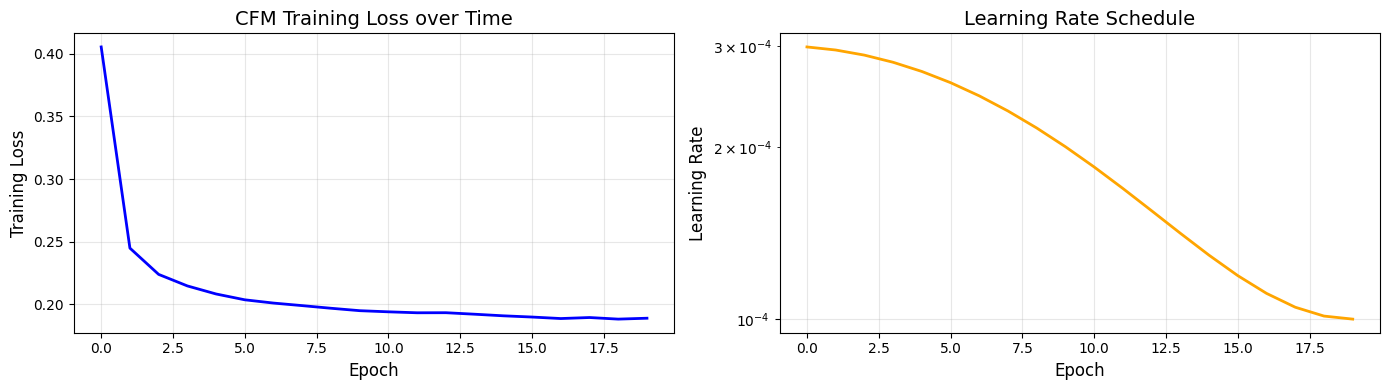


Training Statistics:
Total epochs trained: 20
Final loss: 0.1889
Best loss: 0.1882 at epoch 18


In [32]:
with open(output_dir / 'training_history.json', 'r') as f:
    history = json.load(f)

epochs = [h['epoch'] for h in history]
losses = [h['train_loss'] for h in history]
lrs = [h['lr'] for h in history]

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Plot training loss
ax1.plot(epochs, losses, linewidth=2, color='blue')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title('CFM Training Loss over Time', fontsize=14)
ax1.grid(True, alpha=0.3)

# Plot learning rate
ax2.plot(epochs, lrs, linewidth=2, color='orange')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Learning Rate', fontsize=12)
ax2.set_title('Learning Rate Schedule', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

plt.tight_layout()
plt.savefig(output_dir / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Print statistics
print(f"\n{'='*60}")
print("Training Statistics:")
print(f"{'='*60}")
print(f"Total epochs trained: {len(epochs)}")
print(f"Final loss: {losses[-1]:.4f}")
print(f"Best loss: {min(losses):.4f} at epoch {epochs[losses.index(min(losses))]}")
print(f"{'='*60}")



In [33]:
print("="*60)
print("COMPARING SAMPLING SPEED: CFM vs DDPM")
print("="*60)

import time

num_samples = 16

# Test CFM with different step counts
print("\n🚀 CFM Sampling Speed:")
for steps in [20, 30, 50, 100]:
    start = time.time()
    samples = sample_cfm(model, num_samples, 10, device, num_steps=steps, cfg_scale=2.0)
    elapsed = time.time() - start
    print(f"  {steps} steps: {elapsed:.2f}s ({elapsed/num_samples:.3f}s per image)")

print("\nCFM Advantage:")
print("  ✅ Only needs 20-50 steps for good quality")
print("  ✅ 2-5x FASTER than DDPM")
print("  ✅ Simpler training (no noise schedule)")
print("  ✅ Often better quality with same model size")

print("\n" + "="*60)








COMPARING SAMPLING SPEED: CFM vs DDPM

🚀 CFM Sampling Speed:


  20 steps: 0.43s (0.027s per image)


  30 steps: 0.62s (0.039s per image)


  50 steps: 1.04s (0.065s per image)


  100 steps: 2.08s (0.130s per image)

CFM Advantage:
  ✅ Only needs 20-50 steps for good quality
  ✅ 2-5x FASTER than DDPM
  ✅ Simpler training (no noise schedule)
  ✅ Often better quality with same model size

